In [80]:
class Layer(object):
    
    def __init__(self):
        self.parameters = list()
        
    def get_parameters(self):
        return self.parameters


class Linear(Layer):

    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)
        self.bias = Tensor(np.zeros(n_outputs), autograd=True) #편향가중치 추가
        
        self.parameters.append(self.weight)
        self.parameters.append(self.bias)
       
    def forward(self, input):
        return input.mm(self.weight)+self.bias.expand(0,len(input.data))
    
        #print(W)
        #print(self.weight)
        #print(self.bias)
        #print(self.parameters.append(self.weight))
        #print(self.parameters.append(self.bias))
        #print(input.mm(self.weight)+self.bias.expand(0,len(input.data)))

In [81]:
class Embedding(Layer):
    
    def __init__(self, vocab_size, dim):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.dim = dim
        
        # 이 초기화 스타일은 word2vec에서 가져온 겁니다.
        self.weight = Tensor((np.random.rand(vocab_size, dim) - 0.5) / dim, autograd=True)
        
        self.parameters.append(self.weight)
    
    def forward(self, input):
        return self.weight.index_select(input)

In [82]:
# 최적화기 - 배치 크기가 1인 경사하강법
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0
        
    def step(self, zero=True):
        
        for p in self.parameters:
            
            p.data -= p.grad.data * self.alpha #갱신단계
            
            if(zero):
                p.grad.data *= 0

In [83]:
class Sequential(Layer):
    
    def __init__(self, layers=list()):
        super().__init__()
        
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
        
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params
    
import numpy
np.random.seed(0)

data = Tensor(np.array([[0,0],[0,1],[1,0],[1,1]]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)
print(data)
print(target)
print('===================')

model = Sequential([Linear(2,3), Linear(3,1)])

optim = SGD(parameters=model.get_parameters(), alpha=0.05)

for i in range(10):
    
    # Predict
    pred = model.forward(data)
    
    # Compare
    loss = ((pred - target)*(pred - target)).sum(0)
    
    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

[[0 0]
 [0 1]
 [1 0]
 [1 1]]
[[0]
 [1]
 [0]
 [1]]
[2.33428272]
[0.06743796]
[0.0521849]
[0.04079507]
[0.03184365]
[0.02479336]
[0.01925443]
[0.01491699]
[0.01153118]
[0.00889602]


## Part 16: The Cross Entropy Layer

### Cross-entropy 


예측 모형은 실제 분포인 q 를 모르고, 모델링을 하여 q 분포를 예측하고자 하는 것이다. 예측 모델링을 통해 구한 분포를 p(x) 라고 해보자. 실제 분포인 q를 예측하는 p 분포를 만들었을 때, 이 때 cross-entropy 는 아래와 같이 정의된다. 

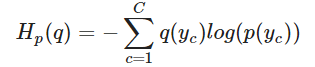


이 때, q와 p가 모두 식에 들어가기 때문에, cross-entropy 라는 이름이 붙었다고 할 수 있다. 머신러닝을 통한 예측 모형에서 훈련 데이터에서는 실제 분포인 p 를 알 수 있기 때문에 cross-entropy 를 계산할 수 있다.  
**즉, 훈련 데이터를 사용한 예측 모형에서 cross-entropy 는 실제 값과 예측값의 차이 (dissimilarity) 를 계산하는데 사용할 수 있다는 것이다.** 또한, Cross-entropy > entropy 이다. 



예를 들어, 가방에 0.8/0.1/0.1 의 비율로, 빨간/녹색/노랑 공이 들어가 있다고 하자, 하지만 직감에는 0.2/0.2/0.6의 비율로 들어가 있을 것 같다. 이 때, entropy 와 cross-entropy 는 아래와 같이 계산된다. 



H(q)=−[0.8log(0.8)+0.1log(0.1)+0.1log(0.1)]=0.63
Hp(q)=−[0.8log(0.2)+0.1log(0.2)+0.1log(0.6)]=1.50

In [97]:
# 자동미분업그레이드
import numpy as np

class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
        
       # =============================================================== #
                #Tensor 클래스의 backward() 메소드 중 일부
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
     # =============================================================== #
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
 # =============================================================== #
    # 역자주_다음 코드는 Tensor 클래스 멤버인 cross_entropy()이다.
    def cross_entropy(self, target_indices):

        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
        
        # print(t)
        print(p)
        # print(target_dist)
        # print(loss) 
        
        if(self.autograd):
            out = Tensor(loss,
                         autograd=True,
                         creators=[self],
                         creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss),t,p,target_dist,loss

    
 # =============================================================== #      
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  
    
class Tanh(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.tanh()
    
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.sigmoid()

In [86]:
# CrossEntropyLoss 클래스 중 일부
class CrossEntropyLoss(object):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        return input.cross_entropy(target)

In [87]:
import numpy
np.random.seed(0)

# data indices
data = Tensor(np.array([1,2,1,2]), autograd=True)
print(data)

# target indices
target = Tensor(np.array([0,1,0,1]), autograd=True)
print(target)
print()

model = Sequential([Embedding(3,3), Tanh(), Linear(3,4)])
criterion = CrossEntropyLoss()
print(t)
print(p)
print(target_dist)
print()
print(model)
print(criterion)
print()

optim = SGD(parameters=model.get_parameters(), alpha=0.1)

for i in range(10):
    
    # Predict
    pred = model.forward(data)
    
    # Compare
    loss = criterion.forward(pred, target)
    
    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

[1 2 1 2]
[0 1 0 1]


1.3885032434928422
0.9558181509266037
0.6823083585795604
0.5095259967493119
0.39574491472895856
0.31752527285348264
0.2617222861964216
0.22061283923954234
0.18946427334830068
0.16527389263866668


* 과거 여러 신경망에 탑재했던 교차 엔트로피(cross entropy) 논리를 그대로 활용한 **새로운 손실 함수**가 생겼다.  
* 다른 손실 함수와 다른 점은 <U>최종 softmax와 손실 계산 모두, 손실 클래스 안에 위치</U>한다는 것=>심층 신경망에서는 평범한 관례  
* 신경망을 종료하고 교체 엔트로피로 학습시키고자 할 때는 순전파 단계에서 softmax를 제외하고,
* 손실함수의 일부로써 softmax를 자동으로 실행하는 교차 트로피 클래스를 호출할 수 있다 .

* 순전파와 역전파를 2개의 다른 모듈로 분리할 때보다 **교차-엔트로피함수 내부**에서 softmax의 경사도와 음의 로그 기능도 모두를 훨씬 빨리 계산해낸다.==> '경사도를 빠르게 구하는 계산법(shortcut for math)'와 관련이 있다.

## Part 17: The Recurrent Neural Network Layer
#### 여러 계층을 결합하면 시계열을  학습할 수 있다.
* 조그만 유형의 계층 여럿을 결합하는 계층을 하나 더 만들어보자.  
* 바로, **순환계층(recurrent layer)**
=> 순환 계층은 3개의 선형 계층을 이용해서 구축하며 .forward()메소드는 이전 은닉 상태에서 나온 출력과 현재 학습 데이터에서 나온 입력 모두를 취한다.

In [88]:
class RNNCell(Layer):
    
    def __init__(self, n_inputs, n_hidden, n_output, activation='sigmoid'):
        super().__init__()

        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        if(activation == 'sigmoid'):
            self.activation = Sigmoid()
        elif(activation == 'tanh'):
            self.activation == Tanh()
        else:
            raise Exception("Non-linearity not found")

        self.w_ih = Linear(n_inputs, n_hidden)
        self.w_hh = Linear(n_hidden, n_hidden)
        self.w_ho = Linear(n_hidden, n_output)
        
        self.parameters += self.w_ih.get_parameters()
        self.parameters += self.w_hh.get_parameters()
        self.parameters += self.w_ho.get_parameters()        
    
    def forward(self, input, hidden):
        from_prev_hidden = self.w_hh.forward(hidden)
        combined = self.w_ih.forward(input) + from_prev_hidden
        new_hidden = self.activation.forward(combined)
        output = self.w_ho.forward(new_hidden)
        return output, new_hidden
    
    #print(from_prev_hidden = self.w_hh.forward(hidden))
    #print(combined = self.w_ih.forward(input) + from_prev_hidden)
    #print(new_hidden = self.activation.forward(combined))
    #print(output = self.w_ho.forward(new_hidden))
    
    def init_hidden(self, batch_size=1):
        return Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)

NameError: name 'self' is not defined

RNN은 시간 단계에서 시간 단계로 전해시는 상태 벡터를 갖고 있다. 위 예제에서는 **hidden**이라는 변수가 바로 **상태 벡터**이다.  
또한, hidden은 forward()함수에 대한 입력 매개변수이자, 출력변수이기도 하다.  

* RNN 역시 여러 가지 가중치 행렬을 가진다.
* 어떤 가중치 행렬은 입력 벡터를 은닉 벡터에 매핑(입력 데이터 처리)하고, 
* 또 어떤 가중치 행렬은 은닉 벡터에서 은닉 벡터로 매핑(이전 은닉 벡터에 기반해서 각 은닉 벡터를 갱신)
* 은닉-출력 계층은 은닉 벡터에 기반해서 예측하는 법을 학습한다.

**RNNCell구현은 이 세 가지를 모두 포함한다.(self.w_ih 계층은 입력-은닉 계층, self.w_hh는 은닉-은닉 계층, self.w_ho는 은닉-출력 계층)**

* self.w_ih의 입력 키기와 self.w_ho의 출력 크기는 모두 어휘의 크기와 같다. 
* 다른 나머지 차원수는 n_hidden 매개변수를 이용해서 조정할 수 있다.

* activation 입력 매개변수는 어떤 비선형성이 어떤 시간 단계에서 은닉 벡터에 적용되었는지를 정의한다.

In [89]:
import sys,random,math
from collections import Counter
import numpy as np

f = open('tasksv11/en/qa1_single-supporting-fact_train.txt','r')
raw = f.readlines()
f.close()

tokens = list()
for line in raw[0:1000]:
    tokens.append(line.lower().replace("\n","").split(" ")[1:])

new_tokens = list()
for line in tokens:
    new_tokens.append(['-'] * (6 - len(line)) + line)

tokens = new_tokens

vocab = set()
for sent in tokens:
    for word in sent:
        vocab.add(word)

vocab = list(vocab)

word2index = {}
for i,word in enumerate(vocab):
    word2index[word]=i
    
def words2indices(sentence):
    idx = list()
    for word in sentence:
        idx.append(word2index[word])
    return idx

indices = list()
for line in tokens:
    idx = list()
    for w in line:
        idx.append(word2index[w])
    indices.append(idx)

data = np.array(indices)

##### 앞 장에서 수행했던 과업에 맞게 신경망을 학습시킬 수 있다.

In [90]:

embed = Embedding(vocab_size=len(vocab),dim=16)
model = RNNCell(n_inputs=16, n_hidden=16, n_output=len(vocab))
print(embed)
print(model)

criterion = CrossEntropyLoss()
optim = SGD(parameters=model.get_parameters() + embed.get_parameters(), alpha=0.05)

임의 개수의 셀을 함께 설정할 수 있는 능력을 제공하는 어떤 계층을 만들어냈다면, 그 계층은 RNN이라는 이름을 얻게 되고 n_layers는 입력 매개변수가 되었을 것이다.

In [35]:
for iter in range(1000):
    batch_size = 100
    total_loss = 0
    
    hidden = model.init_hidden(batch_size=batch_size)

    for t in range(5):
        input = Tensor(data[0:batch_size,t], autograd=True)
        rnn_input = embed.forward(input=input)
        output, hidden = model.forward(input=rnn_input, hidden=hidden)

    target = Tensor(data[0:batch_size,t+1], autograd=True)    
    loss = criterion.forward(output, target)
    loss.backward()
    optim.step()
    total_loss += loss.data
    if(iter % 200 == 0):
        p_correct = (target.data == np.argmax(output.data,axis=1)).mean()
        print("Loss:",total_loss / (len(data)/batch_size),"% Correct:",p_correct)

Loss: 0.4509692171421455 % Correct: 0.0
Loss: 0.17390647939421655 % Correct: 0.27
Loss: 0.1551120990569272 % Correct: 0.33
Loss: 0.13946057897029826 % Correct: 0.37
Loss: 0.13760040026494857 % Correct: 0.37


In [92]:
batch_size = 1
hidden = model.init_hidden(batch_size=batch_size)
for t in range(5):
    input = Tensor(data[0:batch_size,t], autograd=True)
    rnn_input = embed.forward(input=input)
    output, hidden = model.forward(input=rnn_input, hidden=hidden)

target = Tensor(data[0:batch_size,t+1], autograd=True)    
loss = criterion.forward(output, target)
print(target)
print(loss)
print()

ctx = ""
for idx in data[0:batch_size][0][0:-1]:
    ctx += vocab[idx] + " "
print("Context:",ctx)
print("True:",vocab[target.data[0]])
print("Pred:", vocab[output.data.argmax()])

[21]
4.723707807286633

Context: - mary moved to the 
True: bathroom.
Pred: 	kitchen	14


(37%의 정확도, 장난감 과업에 대해선 거의 완벽한 수준)=>mary가 갈 장소를 그럴듯하게 예측

### 요약
#### 프레임워크는 전파와 전파 논리의 효율적이며 간편한 추상화이다.
* 프레임워크는 코드에 관해 읽기는 수월하게, 작성은 빠르게, 실행도 빠르게 (내장 최적화 기능을 통해),버그는 적게 만들어준다.
*